<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [0]:
import pandas as pd
import numpy as np
import PIL
import cv2 as cv
from keras import models, layers, callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

In [19]:
!wget https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/common.py -O "common.py"
from common import *

--2020-01-16 13:31:25--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/definitions/common.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4100 (4.0K) [text/plain]
Saving to: ‘common.py’

common.py           100%[===================>]   4.00K  --.-KB/s    in 0s      

2020-01-16 13:31:25 (121 MB/s) - ‘common.py’ saved [4100/4100]



In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!cp "./drive/My Drive/sudoku_acquisition_output.bz2" "./sudoku_acquisition_output.bz2"
acquisition_output = pd.read_pickle("./sudoku_acquisition_output.bz2")
acquisition_output

,input_image,input_digits,input_classes,training
input_filename,,,,
./v2_train/image169.jpg,"[[[164, 161, 118], [164, 161, 118], [164, 161,...","[[8, 3, 0, 0, 0, 7, 9, 0, 0], [0, 0, 0, 0, 3, ...","[[1, 1, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 1, ...",False
./v2_train/image72.jpg,"[[[169, 168, 147], [169, 168, 147], [169, 168,...","[[0, 7, 1, 9, 0, 2, 0, 5, 0], [0, 0, 0, 0, 0, ...","[[0, 1, 1, 1, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, ...",False
./v2_train/image1066.jpg,"[[[146, 143, 147], [146, 143, 147], [147, 145,...","[[1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 6, 0, 1, 5, ...","[[1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 1, ...",False
./v2_train/image1087.jpg,"[[[47, 42, 43], [48, 44, 41], [46, 45, 42], [4...","[[0, 0, 2, 0, 0, 9, 1, 0, 5], [0, 8, 0, 7, 0, ...","[[0, 0, 1, 0, 0, 1, 1, 0, 1], [0, 1, 0, 1, 0, ...",True
./v2_train/image204.jpg,"[[[154, 146, 93], [158, 150, 103], [163, 154, ...","[[0, 1, 3, 0, 0, 0, 0, 0, 0], [0, 0, 6, 0, 4, ...","[[0, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, ...",True
...,...,...,...,...
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165358878.jpg,"[[[77, 75, 78], [77, 75, 78], [78, 76, 79], [7...","[[2, 4, 7, 9, 9, 4, 7, 6, 1], [8, 7, 6, 2, 6, ...","[[2, 2, 2, 2, 2, 2, 1, 2, 1], [1, 2, 2, 2, 2, ...",True
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165329872.jpg,"[[[133, 127, 105], [132, 126, 104], [133, 127,...","[[2, 4, 7, 9, 9, 4, 7, 6, 1], [8, 7, 6, 2, 6, ...","[[2, 2, 2, 2, 2, 2, 1, 2, 1], [1, 2, 2, 2, 2, ...",True
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165402379.jpg,"[[[51, 51, 51], [49, 49, 49], [46, 46, 46], [4...","[[2, 4, 7, 9, 9, 4, 7, 6, 1], [8, 7, 6, 2, 6, ...","[[2, 2, 2, 2, 2, 2, 1, 2, 1], [1, 2, 2, 2, 2, ...",True


In [22]:
!cp "./drive/My Drive/sudoku_extraction_output.bz2" "./sudoku_extraction_output.bz2"
extraction_output = pd.read_pickle("./sudoku_extraction_output.bz2")
extraction_output

cell_image
input_filename                                     cell_row cell_col                                                   
./v2_train/image1066.jpg                           0        0         [[[95, 93, 91], [84, 81, 80], [79, 76, 75], [7...
                                                            1         [[[57, 54, 52], [60, 56, 54], [58, 54, 52], [5...
                                                            2         [[[62, 57, 58], [65, 61, 61], [67, 62, 62], [6...
                                                            3         [[[61, 59, 58], [60, 58, 57], [64, 63, 61], [6...
                                                            4         [[[77, 75, 76], [76, 73, 75], [72, 70, 72], [7...
...                                                                                                                 ...
./sudoku_dataset_1024/train_247994761_full/IMG_... 8        4         [[[148, 142, 123], [123, 116, 98], [151, 144, ...
                                                            5         [[[143, 136, 118], [161, 154, 136], [174, 167,...
                                                            6         [[[87, 81, 65], [164, 158, 142], [179, 173, 15...
                                                            7         [[[164, 158, 142], [180, 174, 158], [180, 175,...
                                                            8         [[[170, 165, 146], [171, 166, 147], [172, 167,...

[15876 rows x 1 columns]

In [23]:
dataset = extraction_output.copy()
dataset["input_digit"] = [acquisition_output.loc[filename]["input_digits"][row][col] for filename, row, col in extraction_output.index]
dataset["input_class"] = [acquisition_output.loc[filename]["input_classes"][row][col] for filename, row, col in extraction_output.index]
dataset["training"] = [acquisition_output.loc[filename]["training"] for filename, _, _ in extraction_output.index]
dataset

cell_image  ...  training
input_filename                                     cell_row cell_col                                                     ...          
./v2_train/image1066.jpg                           0        0         [[[95, 93, 91], [84, 81, 80], [79, 76, 75], [7...  ...     False
                                                            1         [[[57, 54, 52], [60, 56, 54], [58, 54, 52], [5...  ...     False
                                                            2         [[[62, 57, 58], [65, 61, 61], [67, 62, 62], [6...  ...     False
                                                            3         [[[61, 59, 58], [60, 58, 57], [64, 63, 61], [6...  ...     False
                                                            4         [[[77, 75, 76], [76, 73, 75], [72, 70, 72], [7...  ...     False
...                                                                                                                 ...  ...       ...
./sudoku_dataset_1024/train_247994761_full/IMG_... 8        4         [[[148, 142, 123], [123, 116, 98], [151, 144, ...  ...      True
                                                            5         [[[143, 136, 118], [161, 154, 136], [174, 167,...  ...      True
                                                            6         [[[87, 81, 65], [164, 158, 142], [179, 173, 15...  ...      True
                                                            7         [[[164, 158, 142], [180, 174, 158], [180, 175,...  ...      True
                                                            8         [[[170, 165, 146], [171, 166, 147], [172, 167,...  ...      True

[15876 rows x 4 columns]

# Introduction

As per the last step we now have images of all Sudoku cells.
Within each image there is either a digit from 1 to 9 or it is empty (at least we assume so).
Our Sudoku reader has to classify these images and bring them in a suitable format before we can use a Sudoku solver to solve the actual puzzle problem. 

# Splitting dataset into train and test subsets

In the acquistion step we already labelled all input images as whether they should be used for *training* or *testing*/*validation*.
This is necessary as we want to know whether or not our solution actually works for other input images we have not looked at before.

## Train subset

Images that should be used for training purposes are labelled with `training = True`.

In [24]:
train = dataset[dataset["training"] == True]
print("Training dataset contains %d samples!" % len(train))

Training dataset contains 9315 samples!


In [25]:
train

cell_image  ...  training
input_filename                                     cell_row cell_col                                                     ...          
./v2_train/image1087.jpg                           0        0         [[[118, 118, 114], [54, 52, 48], [59, 56, 52],...  ...      True
                                                            1         [[[58, 54, 51], [55, 51, 48], [55, 51, 49], [5...  ...      True
                                                            2         [[[55, 50, 47], [57, 53, 50], [57, 53, 50], [5...  ...      True
                                                            3         [[[59, 55, 52], [61, 56, 54], [62, 57, 56], [6...  ...      True
                                                            4         [[[68, 65, 62], [67, 64, 62], [66, 63, 62], [6...  ...      True
...                                                                                                                 ...  ...       ...
./sudoku_dataset_1024/train_247994761_full/IMG_... 8        4         [[[148, 142, 123], [123, 116, 98], [151, 144, ...  ...      True
                                                            5         [[[143, 136, 118], [161, 154, 136], [174, 167,...  ...      True
                                                            6         [[[87, 81, 65], [164, 158, 142], [179, 173, 15...  ...      True
                                                            7         [[[164, 158, 142], [180, 174, 158], [180, 175,...  ...      True
                                                            8         [[[170, 165, 146], [171, 166, 147], [172, 167,...  ...      True

[9315 rows x 4 columns]

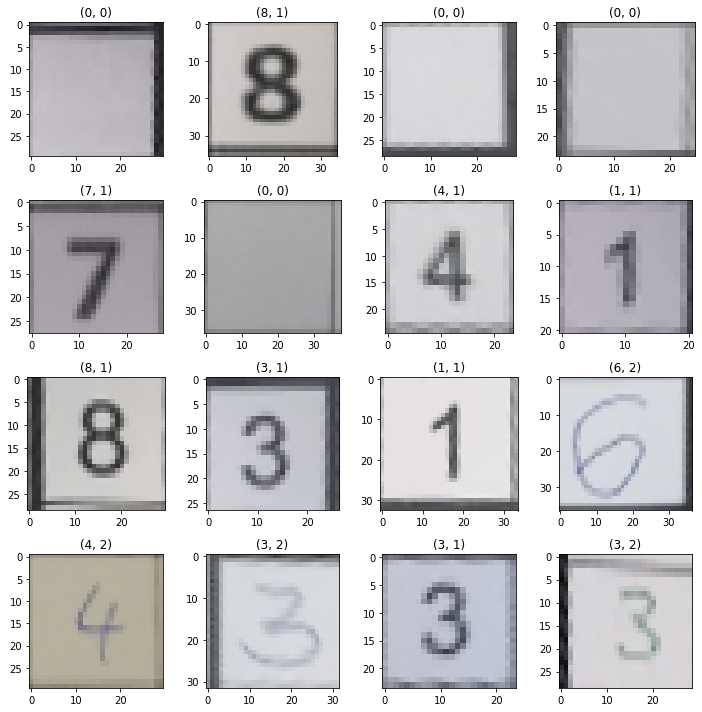

In [26]:
show_images(train["cell_image"], list(zip(train["input_digit"], train["input_class"])), n_samples=16, scaling=(2.5, 2.5))

## Test subset

Images that should be used for testing/validation purposes are labelled with `training = False`.

In [27]:
test = dataset[dataset["training"] == False]
print("Testing dataset contains %d samples!" % len(test))

Testing dataset contains 6561 samples!


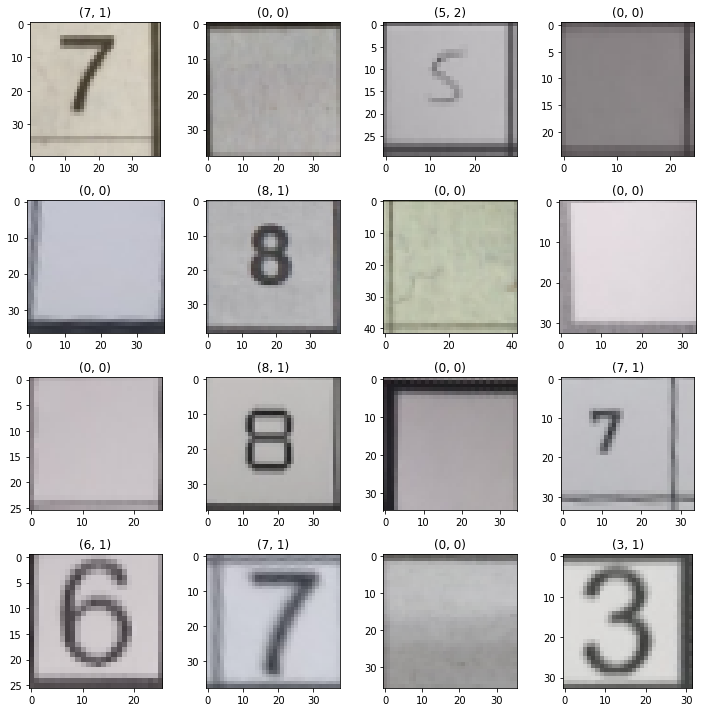

In [28]:
show_images(test["cell_image"], list(zip(test["input_digit"], test["input_class"])), n_samples=16, scaling=(2.5, 2.5))

# Recognize digits using neural networks

We had only limited success with classic means of image recognition like *template matching* so we decided to use *artifical neural networks* for the classification task.
In the following we are discussing different possible network architectures and training methods.
We are using the *Keras* library, which enables us to easily define and train deep neural networks (including convolutional neural networks).

We aim at an accuracy of at least $\frac{80}{81}\approx99\%$ which means we are misclassifying (on average) at most 1 digit per Sudoku puzzle.

## Plain MNIST

The *MNIST database of handwritten digits* is a very popular dataset for machine learning classification tasks.
It contains a large number of 28-by-28 pixel grayscale images of handwritten digits and the corresponding labels from 0 to 9.
Maybe, if we train a neural network on this dataset, this network is then able to also correctly recognize computer generated digits as they usually occur in Sudoku puzzles.

### Acquire dataset

The train and test datasets can easily be acquired using the `keras.datasets.mnist.load_data()` method. 

In [32]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [33]:
print("Train:", mnist_x_train.shape, mnist_y_train.shape)
print("Test:", mnist_x_test.shape, mnist_y_test.shape)

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


Neural networks in general work better with normalized data.
For this reason we scale the 8-bit grayscale values that range from 0 to 255 to a 32-bit float ranging from 0 to 1.

In [0]:
mnist_x_train = mnist_x_train.astype("float32") / 255.0
mnist_x_test = mnist_x_test.astype("float32") / 255.0

As we plan on using convolutional neural networks (CNNs) we must reshape the data to include a third (or fourth) dimension.
The neural network input data is now shaped as follows: (n_samples, width=28, height=28, channels=1)

In [0]:
mnist_x_train = mnist_x_train.reshape(-1, 28, 28, 1)
mnist_x_test = mnist_x_test.reshape(-1, 28, 28, 1)

The following shows a small subset of input images.

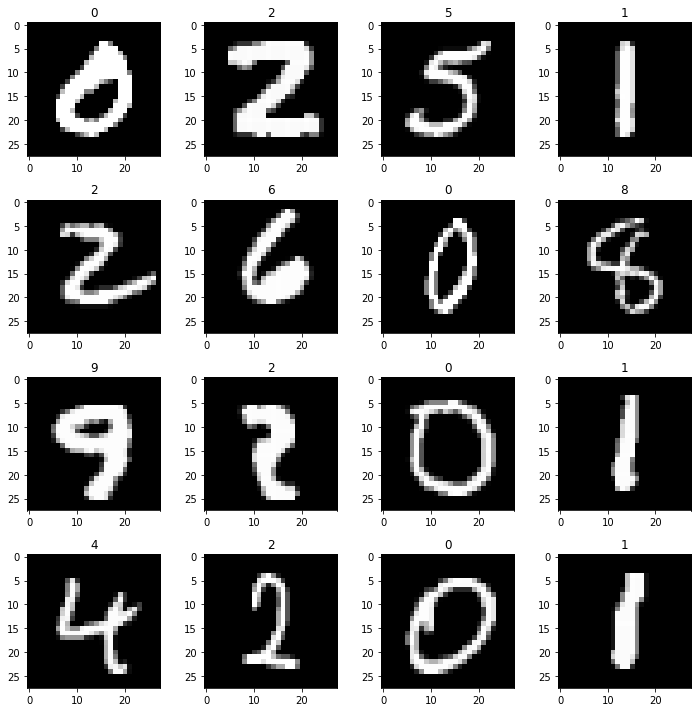

In [36]:
show_images(mnist_x_train, mnist_y_train, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

The architecture itself is inspired by VGGNet (2014).

![VGGNet (2014) architecture](https://miro.medium.com/max/1400/0*V1muWIDnPVwZUuEv.png)

In [44]:
# Input
plainmnist_model = model_input = layers.Input(shape=(28, 28, 1))

# Convolutional Block 1
plainmnist_model = layers.Conv2D(16, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Conv2D(32, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.MaxPool2D()(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dropout(0.25)(plainmnist_model)

# Convolutional Block 2
plainmnist_model = layers.Conv2D(64, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Conv2D(128, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.GlobalMaxPool2D()(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dropout(0.25)(plainmnist_model)

# Fully Connected Block
plainmnist_model = layers.Dense(64, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dense(32, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dense(16, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)

# Output
plainmnist_model = layers.Dense(10, activation="softmax")(plainmnist_model)

plainmnist_model = models.Model(model_input, plainmnist_model)
plainmnist_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
plainmnist_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_45 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 32)        0   

### Fitting the model

We fit the model until the validation loss doesn't improve anymore.
This is achieved using the `EarlyStopping` callback provided by Keras.

In [45]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
fit_history = plainmnist_model.fit(mnist_x_train, mnist_y_train, validation_data=(mnist_x_test, mnist_y_test), epochs=100, callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 32s 526us/step - loss: 0.3605 - acc: 0.8955 - val_loss: 0.0487 - val_acc: 0.9847
Epoch 2/100
60000/60000 [==============================] - 29s 483us/step - loss: 0.1034 - acc: 0.9688 - val_loss: 0.0383 - val_acc: 0.9892
Epoch 3/100
60000/60000 [==============================] - 29s 489us/step - loss: 0.0780 - acc: 0.9765 - val_loss: 0.0356 - val_acc: 0.9888
Epoch 4/100
60000/60000 [==============================] - 29s 488us/step - loss: 0.0659 - acc: 0.9804 - val_loss: 0.0312 - val_acc: 0.9906
Epoch 5/100
60000/60000 [==============================] - 30s 497us/step - loss: 0.0552 - acc: 0.9830 - val_loss: 0.0229 - val_acc: 0.9923
Epoch 6/100
60000/60000 [==============================] - 30s 493us/step - loss: 0.0498 - acc: 0.9848 - val_loss: 0.0229 - val_acc: 0.9928
Epoch 7/100
60000/60000 [==============================] - 30s 498us/step - loss: 0.0480 - acc: 0.9850 - val_l

In [0]:
plainmnist_model.save("plainmnist_model.h5")
!cp "plainmnist_model.h5" "./drive/My Drive/plainmnist_model.h5"

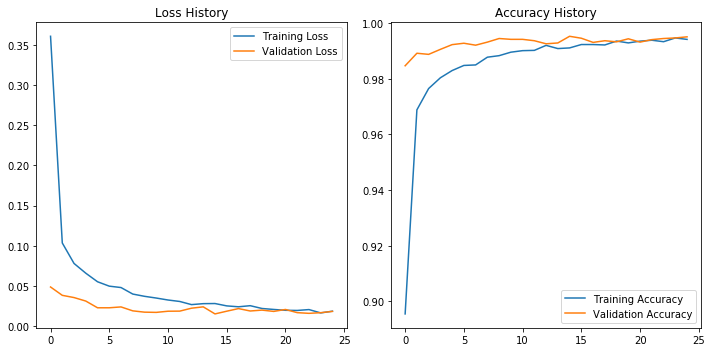

In [46]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
plainmnist_model.evaluate(mnist_x_test, mnist_y_test)

10000/10000 [==============================] - 1s 89us/step


[0.01523348181968322, 0.9953]

### Visualizing the model

The following visualizes the intermediate activations of convolutional layers for a random input image.

Visualizing test image 9955


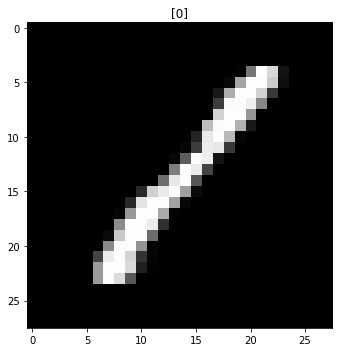

Visualizing layer #1 (conv2d_33)


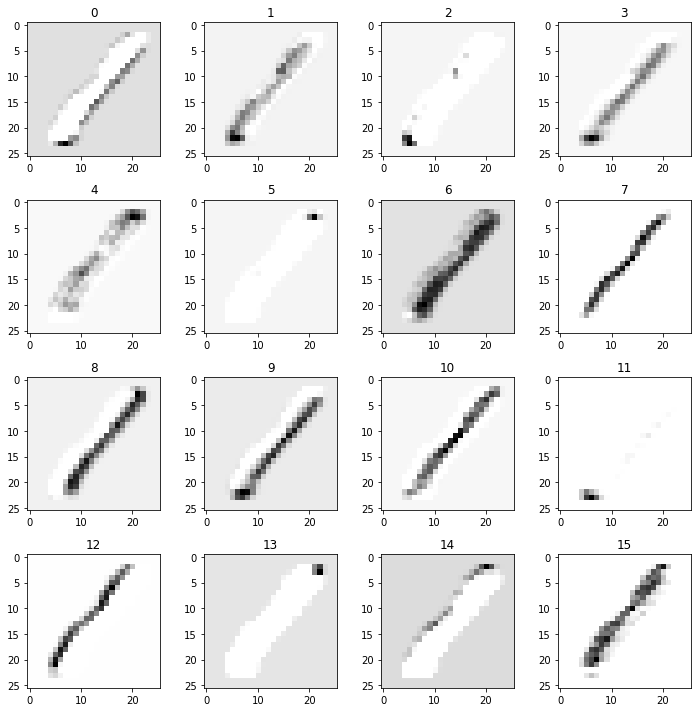

Visualizing layer #3 (conv2d_34)


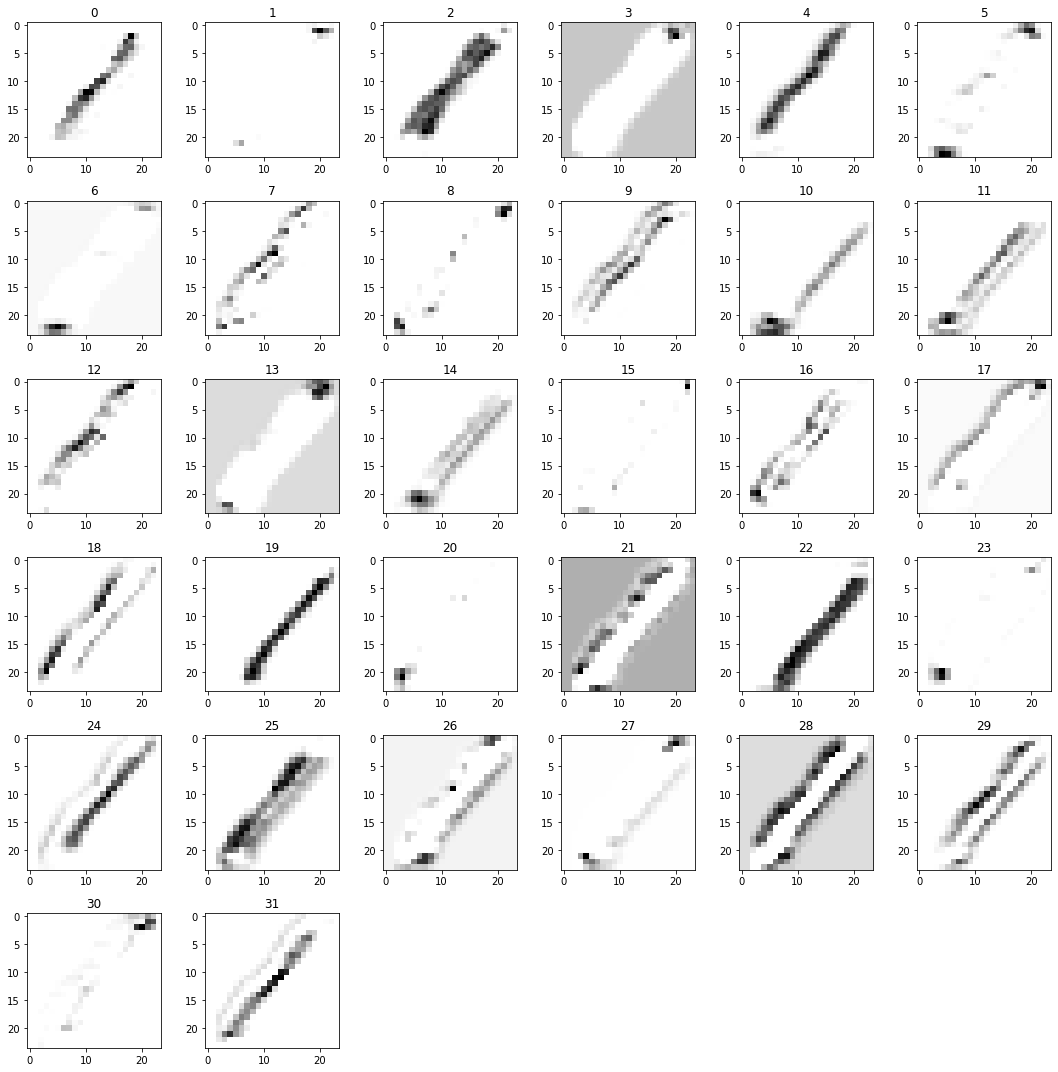

Visualizing layer #7 (conv2d_35)


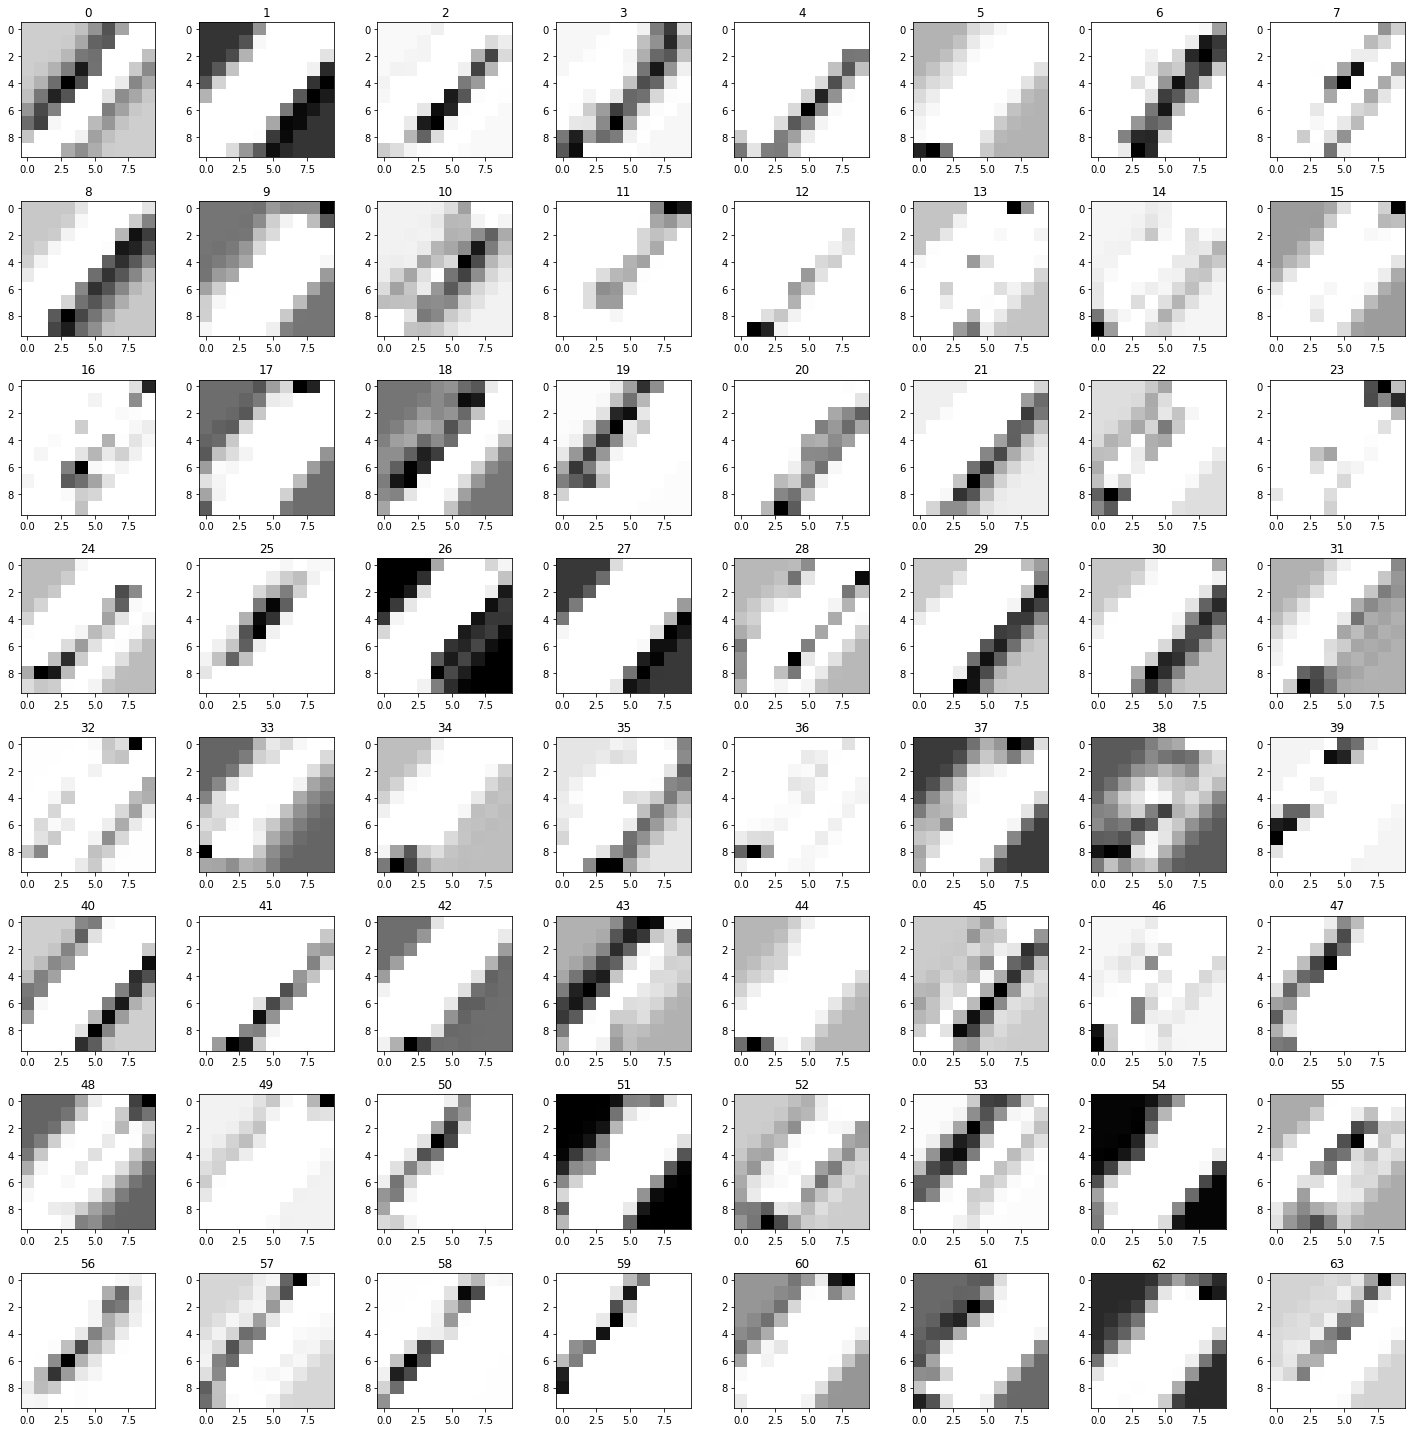

Visualizing layer #9 (conv2d_36)


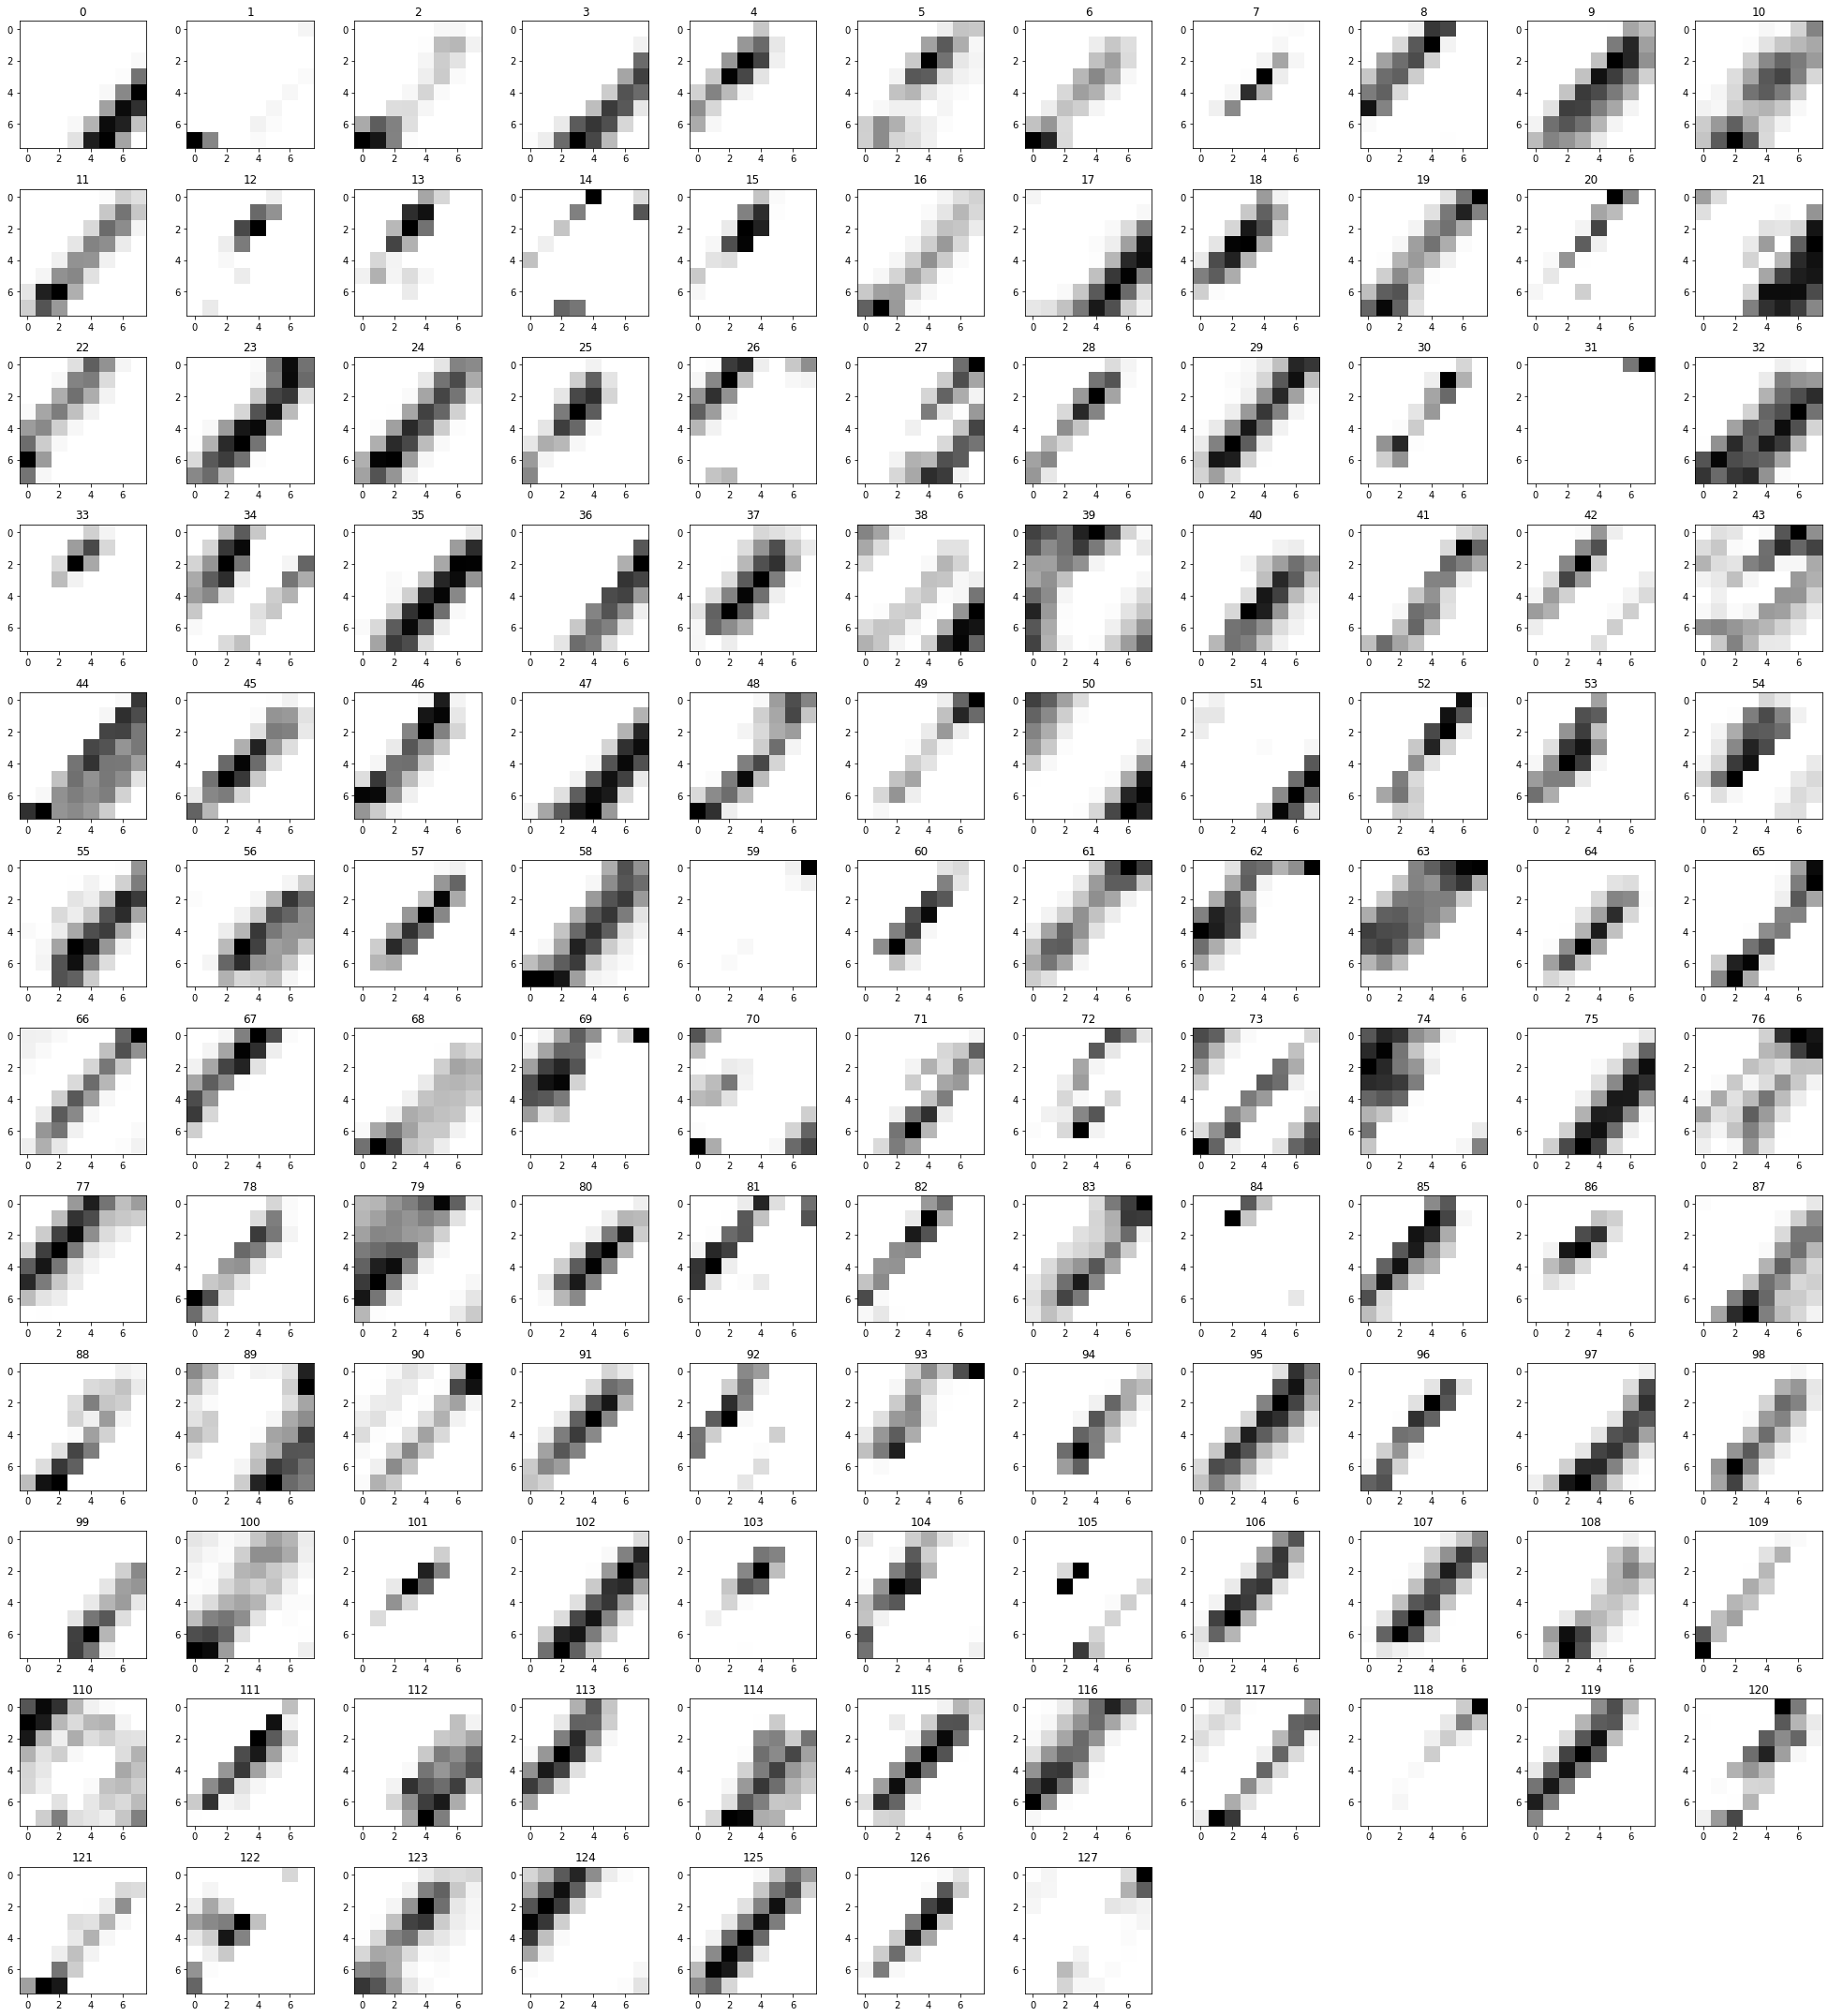

In [195]:
index = random.choice(range(len(mnist_x_test)))
print("Visualizing test image", index)
image = mnist_x_test[index]
show_images([image], cmap="gray")

def nn_get_submodel(model, layer):
  return models.Model(model.input, model.layers[layer].output)

def nn_visualize_layer_activations(model, layer, input):
  submodel = nn_get_submodel(model, layer)
  activations = submodel.predict(np.expand_dims(input, 0))[0]
  activation_channels = np.arange(activations.shape[-1])
  activation_images = [activations[:,:,i] for i in activation_channels]
  show_images(activation_images, activation_channels, cmap="Greys", scaling=(2.5, 2.5), normalize=True)

for i_layer, layer in enumerate(plainmnist_model.layers):
  if layer.name.startswith("conv2d") and len(layer.output.shape) == 4:
    print("Visualizing layer #%d (%s)" % (i_layer, layer.name))
    nn_visualize_layer_activations(plainmnist_model, i_layer, image)

### Evaluating the model

Before we can evaluate the model, we have to preprocess our own samples from the Sudoku dataset so that they are compatible to the network architecture.
This is done by:
- converting from RGB to grayscale
- inverting grayscale values
- normalizing grayscale values to 0..1
- resizing to 28-by-28
- expanding dimensions (-> 3D data)

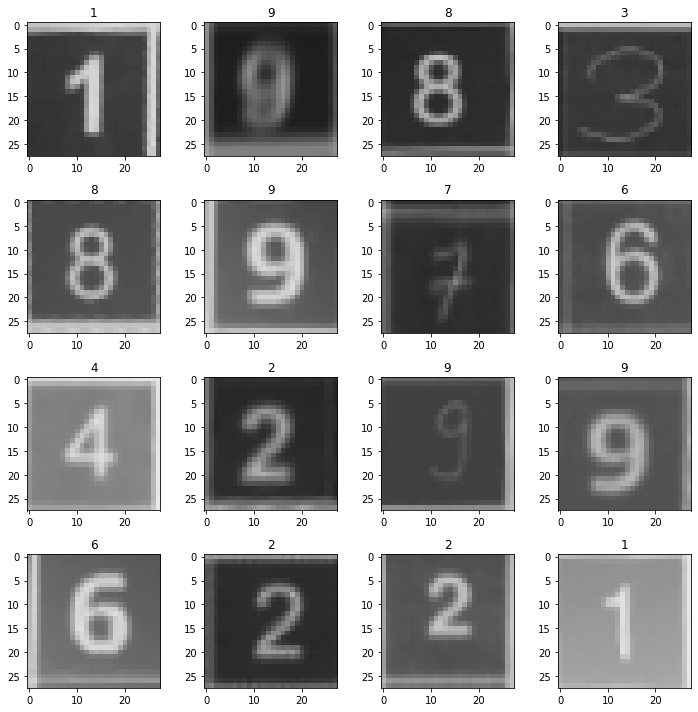

In [49]:
def nn_mnist_preprocess(cell):
  # convert to grayscale
  cell = cv.cvtColor(cell, cv.COLOR_RGB2GRAY)
  # invert:
  cell = 255 - cell
  # normalize:
  cell = cell.astype("float32") / 255.0
  # resize:
  cell = cv.resize(cell, (28, 28), cv.INTER_AREA)
  # expand dims:
  cell = np.expand_dims(cell, axis=2)
  return cell

We also have to make sure we only look at non-zero digits (for now at least), as the MNIST dataset interprets 0 as the actual digit "0", however we interpret 0 as being "empty". 

In [0]:
plainmnist_X_train = np.array([nn_mnist_preprocess(x) for x in train["cell_image"][train["input_digit"] != 0]])
plainmnist_X_test = np.array([nn_mnist_preprocess(x) for x in test["cell_image"][test["input_digit"] != 0]])
plainmnist_Y_train = train["input_digit"][train["input_digit"] != 0].values
plainmnist_Y_test = test["input_digit"][test["input_digit"] != 0].values
show_images(plainmnist_X_train, plainmnist_Y_train, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

Our own test dataset can then be fed into the model.

In [51]:
plainmnist_model.evaluate(plainmnist_X_test, plainmnist_Y_test)

3306/3306 [==============================] - 0s 82us/step


[7.887594699571151, 0.1279491833075926]

In [52]:
plainmnist_Y_pred = plainmnist_model.predict(plainmnist_X_test)
print(classification_report(plainmnist_Y_test, np.argmax(plainmnist_Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.16      0.84      0.27       400
           2       0.00      0.00      0.00       364
           3       0.00      0.00      0.00       438
           4       0.38      0.22      0.28       325
           5       0.00      0.00      0.00       327
           6       0.00      0.00      0.00       383
           7       0.00      0.00      0.00       327
           8       0.38      0.04      0.07       361
           9       0.00      0.00      0.00       381

    accuracy                           0.13      3306
   macro avg       0.09      0.11      0.06      3306
weighted avg       0.10      0.13      0.07      3306



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As shown, the network does not really perform well on our own dataset.
This could be due to a number of reason:

- The MNIST dataset contains only handwritten digits wheras we include both handwritten *and* computer generated ones.
- Our images include cell borders that may confuse the network.
- Our images are relatively low contrast and blurry. 

## Augmented MNIST

Obviously the "Plain MNSIT" model did not generalize very well.
One method to improve generalization is to *augment* the training data.
This can be done by shifting, zooming and rotating (within certain bounds) of the images as these operations do not change how an image should be labelled.

### Acquire dataset

The augmented dataset uses the previous MNIST dataset as a basis.
Data augmentation is realized using Keras' `ImageDataGenerator` class.
Additionally we have written custom methods to randomly change brightness and contrast of input images.

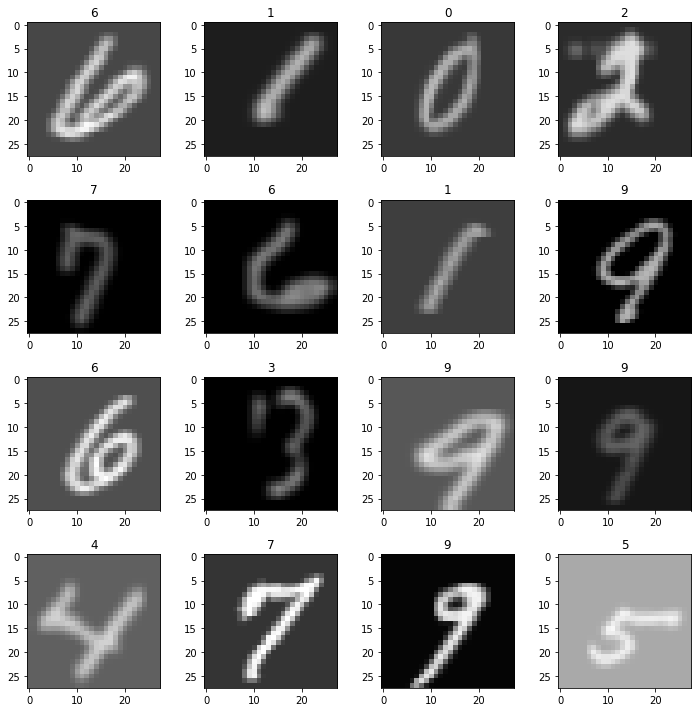

In [62]:
def augmnist_change_brightness(image, factor):
  return image * factor

def augmnist_change_contrast(image, factor):
  return 0.5 + factor * (image - 0.5)

def augmnist_blur(image):
  ksize = np.random.randint(1, 4, size=(2,))
  return cv.blur(src=image, ksize=tuple(ksize))

def augmnist_preprocess(image):
  image = image[:,:,0]
  factor = np.random.rand() * 0.5 + 0.5
  image = augmnist_change_brightness(image, factor)
  factor = np.random.rand() * 0.5 + 0.5
  image = augmnist_change_contrast(image, factor)
  image += np.random.randn() * 0.25
  image = np.clip(image, 0.0, 1.0)
  image = augmnist_blur(image)
  return np.expand_dims(image, axis=2)

generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, shear_range=10.0, preprocessing_function=augmnist_preprocess)
augmnist_generator_train = generator.flow(mnist_x_train, mnist_y_train)
augmnist_generator_test = generator.flow(mnist_x_test, mnist_y_test)
show_images(*augmnist_generator_train[0], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

In [65]:
# Input
augmnist_model = model_input = layers.Input(shape=(28, 28, 1))

# Convolutional Block 1
augmnist_model = layers.Conv2D(16, 3, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Conv2D(32, 3, activation="relu")(augmnist_model)
augmnist_model = layers.MaxPool2D()(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dropout(0.25)(augmnist_model)

# Convolutional Block 2
augmnist_model = layers.Conv2D(64, 3, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Conv2D(128, 3, activation="relu")(augmnist_model)
augmnist_model = layers.GlobalMaxPool2D()(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dropout(0.25)(augmnist_model)

# Fully Connected Block
augmnist_model = layers.Dense(64, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dense(32, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dense(16, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)

# Output
augmnist_model = layers.Dense(10, activation="softmax")(augmnist_model)

augmnist_model = models.Model(model_input, augmnist_model)
augmnist_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
augmnist_model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_59 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_21 (Dropout)         (None, 12, 12, 32)        0  

### Fitting the model

In [66]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
fit_history = augmnist_model.fit_generator(augmnist_generator_train, validation_data=augmnist_generator_test, epochs=100, callbacks=[early_stopping])

Epoch 1/100
1875/1875 [==============================] - 49s 26ms/step - loss: 0.6529 - acc: 0.7947 - val_loss: 0.1351 - val_acc: 0.9591
Epoch 2/100
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1958 - acc: 0.9403 - val_loss: 0.0757 - val_acc: 0.9748
Epoch 3/100
1875/1875 [==============================] - 46s 25ms/step - loss: 0.1463 - acc: 0.9546 - val_loss: 0.1560 - val_acc: 0.9500
Epoch 4/100
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1271 - acc: 0.9607 - val_loss: 0.0759 - val_acc: 0.9758
Epoch 5/100
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1098 - acc: 0.9645 - val_loss: 0.0628 - val_acc: 0.9795
Epoch 6/100
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1035 - acc: 0.9675 - val_loss: 0.0536 - val_acc: 0.9820
Epoch 7/100
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0983 - acc: 0.9688 - val_loss: 0.0555 - val_acc: 0.9804
Epoch 8/100
1875/1875 [==================

In [0]:
augmnist_model.save("augmnist_model.h5")
!cp "augmnist_model.h5" "./drive/My Drive/augmnist_model.h5"

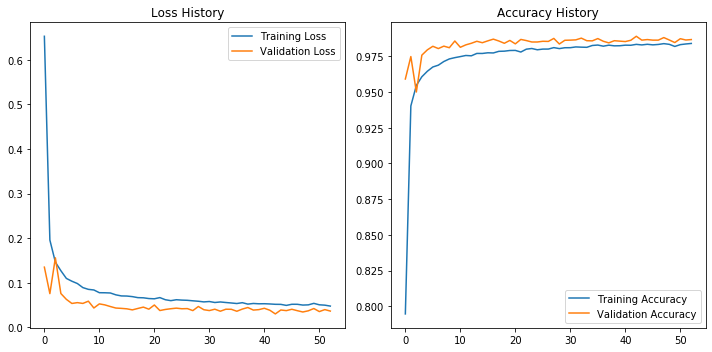

In [70]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
augmnist_model.evaluate_generator(augmnist_generator_test)

[0.03838493714355864, 0.9866]

### Evaluating the model

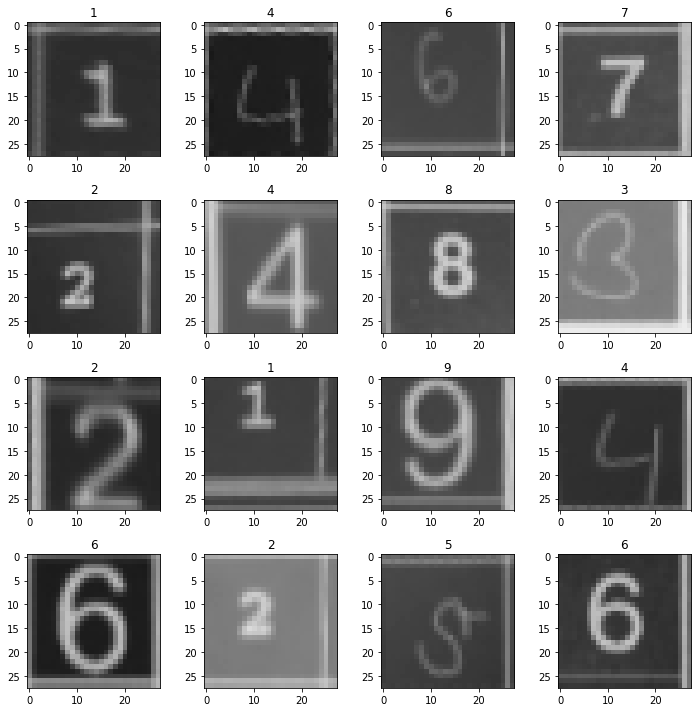

In [72]:
augmnist_X_train = np.array([nn_mnist_preprocess(x) for x in train["cell_image"][train["input_digit"] != 0]])
augmnist_X_test = np.array([nn_mnist_preprocess(x) for x in test["cell_image"][test["input_digit"] != 0]])
augmnist_Y_train = train["input_digit"][train["input_digit"] != 0].values
augmnist_Y_test = test["input_digit"][test["input_digit"] != 0].values
show_images(augmnist_X_test, augmnist_Y_test, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

In [73]:
augmnist_model.evaluate(augmnist_X_test, augmnist_Y_test)

3306/3306 [==============================] - 0s 97us/step


[0.899776881165167, 0.726557773780765]

In [74]:
augmnist_Y_pred = augmnist_model.predict(augmnist_X_test)
print(classification_report(augmnist_Y_test, np.argmax(augmnist_Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.97      0.70      0.81       400
           2       0.81      0.71      0.75       364
           3       0.76      0.93      0.84       438
           4       0.94      0.83      0.88       325
           5       0.42      0.90      0.57       327
           6       0.89      0.50      0.64       383
           7       0.69      0.67      0.68       327
           8       0.88      0.83      0.85       361
           9       0.74      0.48      0.59       381

    accuracy                           0.73      3306
   macro avg       0.71      0.65      0.66      3306
weighted avg       0.79      0.73      0.74      3306



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The "Augmented MNIST" model performs significantly better than the "Plain MNIST" model on our dataset.
Still, an accuracy of about 70% is not enough for a reliable Sudoku solver.
On average about 24 digits per puzzle would be misclassified.

## Sudoku dataset

Obviously we can use our own dataset to train a network.
And that's exactly what we do now.

### Acquire dataset

We use our own dataset for training and prepare it in a similar way to the MNIST images.

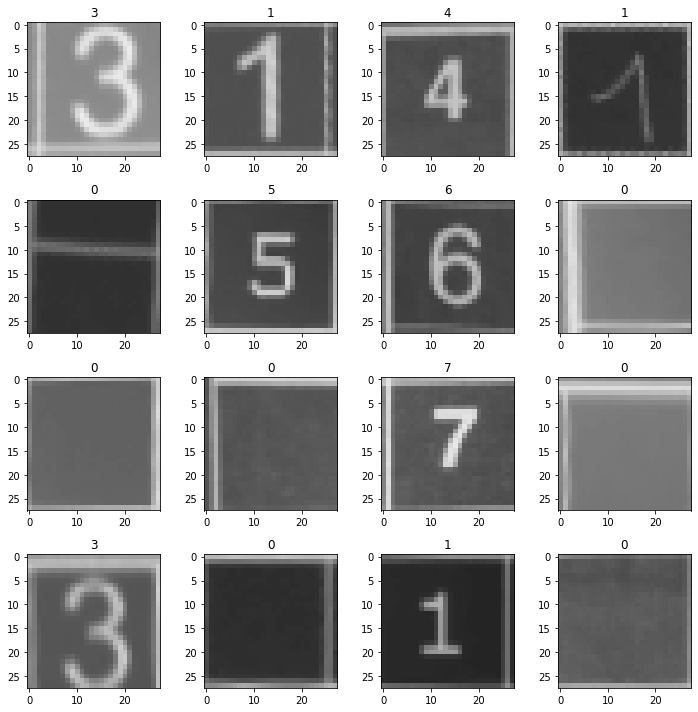

In [75]:
sudnn_X_train = np.array([nn_mnist_preprocess(x) for x in train["cell_image"]])
sudnn_X_test = np.array([nn_mnist_preprocess(x) for x in test["cell_image"]])
sudnn_Y_train = train["input_digit"].values
sudnn_Y_test = test["input_digit"].values
show_images(sudnn_X_test, sudnn_Y_test, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

Because the previous model architecture liked to overfit we significantly reduced the complexity and number of parameters of this model.

In [113]:
# Input
sudnn_model = model_input = layers.Input(shape=(28, 28, 1))

# Convolutional Block 1
sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Conv2D(32, 3, activation="relu")(sudnn_model)
sudnn_model = layers.MaxPool2D()(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Dropout(0.5)(sudnn_model)

# Convolutional Block 2
sudnn_model = layers.Conv2D(32, 3, activation="relu")(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
sudnn_model = layers.GlobalMaxPool2D()(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Dropout(0.5)(sudnn_model)

# Fully Connected Block
# sudnn_model = layers.GaussianNoise(0.1)(sudnn_model)
# sudnn_model = layers.Dense(64, activation="relu")(sudnn_model)
# sudnn_model = layers.BatchNormalization()(sudnn_model)
# sudnn_model = layers.Dense(32, activation="relu")(sudnn_model)
# sudnn_model = layers.BatchNormalization()(sudnn_model)
# sudnn_model = layers.Dense(16, activation="relu")(sudnn_model)
# sudnn_model = layers.BatchNormalization()(sudnn_model)
# sudnn_model = layers.Dropout(0.5)(sudnn_model)

# Output
sudnn_model = layers.Dense(10, activation="softmax")(sudnn_model)

sudnn_model = models.Model(model_input, sudnn_model)
sudnn_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
sudnn_model.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_148 (Bat (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_149 (Bat (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_53 (Dropout)         (None, 12, 12, 32)        0  

### Fitting the model

Our dataset contains an unproportional large number of empty cells.
This has to be accounted for when training.
Otherwise the network could fall back on always predicting class 0 and reach an accuracy of 90% with that!
Obviously such predictions are worthless to us.
This problem of an unbalanced dataset can be somewhat alleviated by assigning a lower class weight to the 0 class. 

The `sklearn.utils.class_weight` package contains a method `compute_class_weight(...)` that computes the necessary class weights to counter the effects of an unbalanced dataset.

In [114]:
class_weight = compute_class_weight("balanced", np.unique(sudnn_Y_train), sudnn_Y_train)
class_weight

array([0.25682382, 1.4692429 , 1.45546875, 1.57082631, 1.54734219,
       1.48328025, 1.36184211, 1.45093458, 1.59503425, 1.36784141])

In [115]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
fit_history = sudnn_model.fit(sudnn_X_train, sudnn_Y_train, 
                              validation_data=(sudnn_X_test, sudnn_Y_test), 
                              epochs=100, callbacks=[early_stopping], 
                              class_weight=class_weight)

Train on 9315 samples, validate on 6561 samples
Epoch 1/100
9315/9315 [==============================] - 10s 1ms/step - loss: 1.6369 - acc: 0.4808 - val_loss: 1.7603 - val_acc: 0.4175
Epoch 2/100
9315/9315 [==============================] - 4s 385us/step - loss: 0.9484 - acc: 0.6938 - val_loss: 0.7422 - val_acc: 0.7884
Epoch 3/100
9315/9315 [==============================] - 4s 389us/step - loss: 0.7007 - acc: 0.7808 - val_loss: 0.6097 - val_acc: 0.8386
Epoch 4/100
9315/9315 [==============================] - 4s 384us/step - loss: 0.5455 - acc: 0.8303 - val_loss: 0.5066 - val_acc: 0.8474
Epoch 5/100
9315/9315 [==============================] - 4s 380us/step - loss: 0.4852 - acc: 0.8406 - val_loss: 0.4344 - val_acc: 0.8671
Epoch 6/100
9315/9315 [==============================] - 4s 403us/step - loss: 0.4092 - acc: 0.8688 - val_loss: 0.4740 - val_acc: 0.8520
Epoch 7/100
9315/9315 [==============================] - 4s 381us/step - loss: 0.3671 - acc: 0.8859 - val_loss: 0.3879 - val_acc: 0

In [0]:
sudnn_model.save("sudnn_model.h5")
!cp "sudnn_model.h5" "./drive/My Drive/sudnn_model.h5"

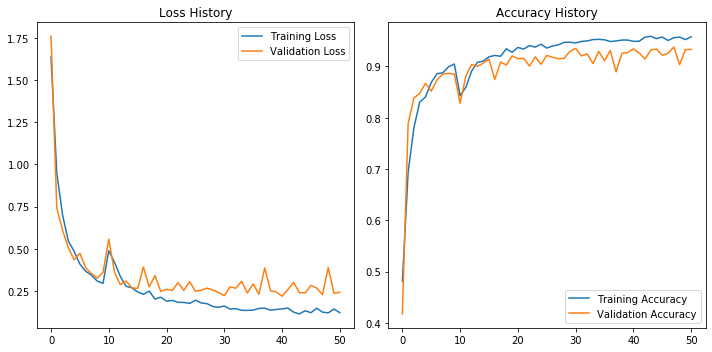

In [119]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

In [120]:
sudnn_model.evaluate(sudnn_X_test, sudnn_Y_test)

6561/6561 [==============================] - 1s 113us/step


[0.2188053641158855, 0.9343087943910989]

### Evaluating the model

In [121]:
sudnn_model.evaluate(sudnn_X_test, sudnn_Y_test)

6561/6561 [==============================] - 1s 109us/step


[0.2188053641158855, 0.9343087943910989]

In [130]:
sudnn_Y_pred = sudnn_model.predict(sudnn_X_test)
sudnn_Y_pred_classes = np.argmax(sudnn_Y_pred, axis=1)
print(classification_report(sudnn_Y_test, sudnn_Y_pred_classes, digits=3))

              precision    recall  f1-score   support

           0      0.969     0.996     0.982      3255
           1      0.949     0.698     0.804       400
           2      0.933     0.799     0.861       364
           3      0.864     0.957     0.908       438
           4      0.798     0.951     0.868       325
           5      0.986     0.862     0.920       327
           6      0.943     0.956     0.949       383
           7      0.823     0.884     0.853       327
           8      0.891     0.903     0.897       361
           9      0.940     0.861     0.899       381

    accuracy                          0.934      6561
   macro avg      0.910     0.887     0.894      6561
weighted avg      0.937     0.934     0.933      6561



#### Correctly classified samples

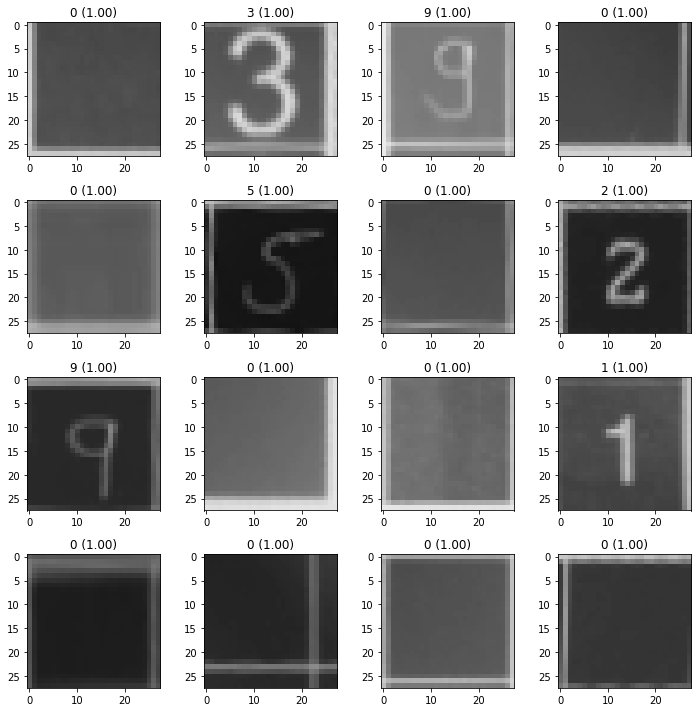

In [133]:
correct_examples = sudnn_Y_pred_classes == sudnn_Y_test
show_images(sudnn_X_test[correct_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in sudnn_Y_pred[correct_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Incorrectly classified samples

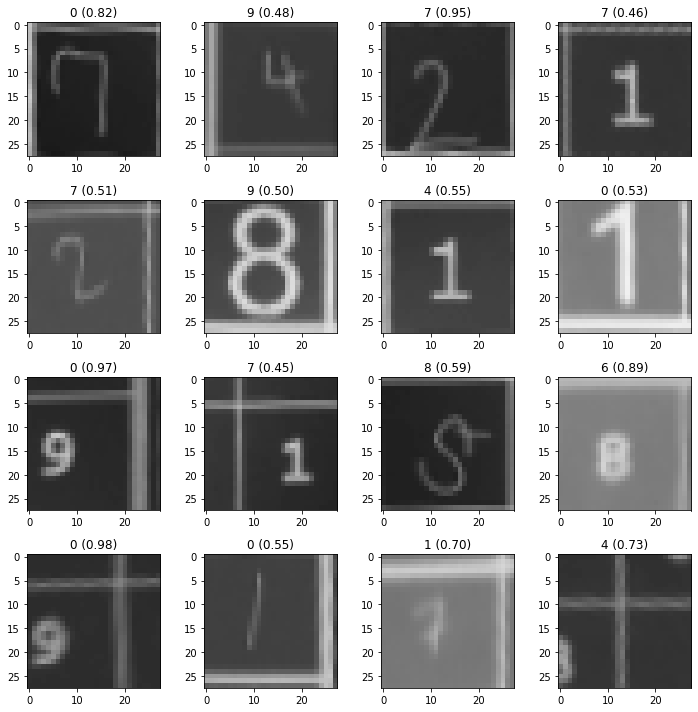

In [134]:
incorrect_examples = sudnn_Y_pred_classes != sudnn_Y_test
show_images(sudnn_X_test[incorrect_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in sudnn_Y_pred[incorrect_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

This model achieves an accuracy of about 93% on our test dataset - still not good enough for our use case.

## Augmented Sudoku dataset

Maybe we can use augmentation once again to improve our accuracy on the test dataset?


### Acquire dataset

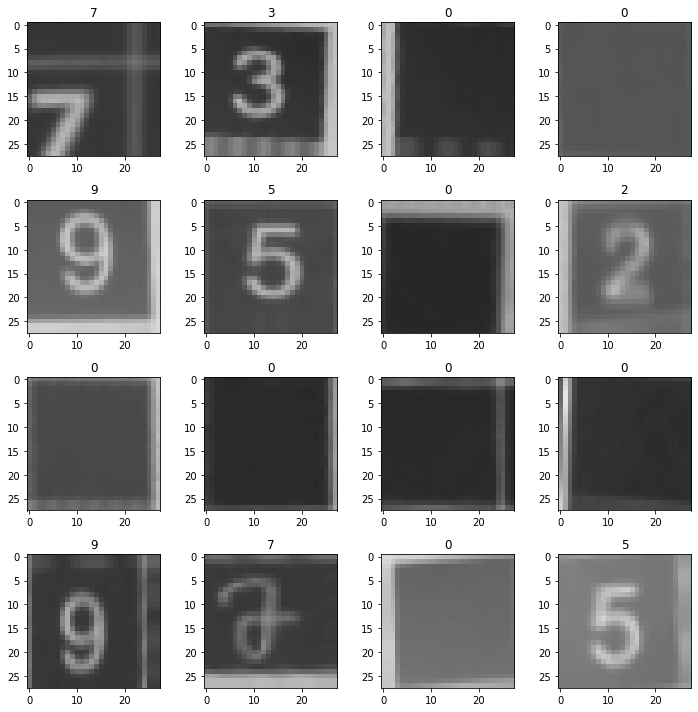

In [149]:
augsud_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                      zoom_range=0.1, shear_range=2.5, rotation_range=2.5)

augsud_train = augsud_generator.flow(sudnn_X_train, sudnn_Y_train)
augsud_X_test = sudnn_X_test
augsud_Y_test = sudnn_Y_test
show_images(*augsud_train[0], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

In [141]:
# Input
augsud_model = model_input = layers.Input(shape=(28, 28, 1))

# Convolutional Block 1
augsud_model = layers.Conv2D(16, 3, activation="relu")(augsud_model)
augsud_model = layers.BatchNormalization()(augsud_model)
augsud_model = layers.Conv2D(32, 3, activation="relu")(augsud_model)
augsud_model = layers.MaxPool2D()(augsud_model)
augsud_model = layers.BatchNormalization()(augsud_model)
augsud_model = layers.Dropout(0.5)(augsud_model)

# Convolutional Block 2
augsud_model = layers.Conv2D(32, 3, activation="relu")(augsud_model)
augsud_model = layers.BatchNormalization()(augsud_model)
augsud_model = layers.Conv2D(16, 3, activation="relu")(augsud_model)
augsud_model = layers.GlobalMaxPool2D()(augsud_model)
augsud_model = layers.BatchNormalization()(augsud_model)
augsud_model = layers.Dropout(0.5)(augsud_model)

# Fully Connected Block
# augsud_model = layers.GaussianNoise(0.1)(augsud_model)
# augsud_model = layers.Dense(64, activation="relu")(augsud_model)
# augsud_model = layers.BatchNormalization()(augsud_model)
# augsud_model = layers.Dense(32, activation="relu")(augsud_model)
# augsud_model = layers.BatchNormalization()(augsud_model)
# augsud_model = layers.Dense(16, activation="relu")(augsud_model)
# augsud_model = layers.BatchNormalization()(augsud_model)
# augsud_model = layers.Dropout(0.5)(augsud_model)

# Output
augsud_model = layers.Dense(10, activation="softmax")(augsud_model)

augsud_model = models.Model(model_input, augsud_model)
augsud_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
augsud_model.summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_159 (Bat (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_160 (Bat (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_57 (Dropout)         (None, 12, 12, 32)        0  

### Fitting the model

In [142]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight("balanced", np.unique(sudnn_Y_train), sudnn_Y_train)
class_weight

array([0.25682382, 1.4692429 , 1.45546875, 1.57082631, 1.54734219,
       1.48328025, 1.36184211, 1.45093458, 1.59503425, 1.36784141])

In [143]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
fit_history = augsud_model.fit_generator(augsud_train, 
                                         validation_data=(augsud_X_test, augsud_Y_test), 
                                         epochs=100, callbacks=[early_stopping], 
                                         class_weight=class_weight)

Epoch 1/100
292/292 [==============================] - 13s 44ms/step - loss: 1.7607 - acc: 0.4430 - val_loss: 2.7299 - val_acc: 0.1780
Epoch 2/100
292/292 [==============================] - 5s 18ms/step - loss: 1.0316 - acc: 0.6626 - val_loss: 0.8746 - val_acc: 0.7545
Epoch 3/100
292/292 [==============================] - 5s 18ms/step - loss: 0.7270 - acc: 0.7662 - val_loss: 0.6915 - val_acc: 0.8182
Epoch 4/100
292/292 [==============================] - 6s 19ms/step - loss: 0.5872 - acc: 0.8177 - val_loss: 0.4591 - val_acc: 0.8793
Epoch 5/100
292/292 [==============================] - 6s 19ms/step - loss: 0.4801 - acc: 0.8481 - val_loss: 0.3630 - val_acc: 0.8964
Epoch 6/100
292/292 [==============================] - 5s 18ms/step - loss: 0.4435 - acc: 0.8623 - val_loss: 0.3530 - val_acc: 0.8906
Epoch 7/100
292/292 [==============================] - 5s 18ms/step - loss: 0.3899 - acc: 0.8764 - val_loss: 0.3356 - val_acc: 0.9067
Epoch 8/100
292/292 [==============================] - 5s 19m

In [0]:
augsud_model.save("augsud_model.h5")
!cp "augsud_model.h5" "./drive/My Drive/augsud_model.h5"

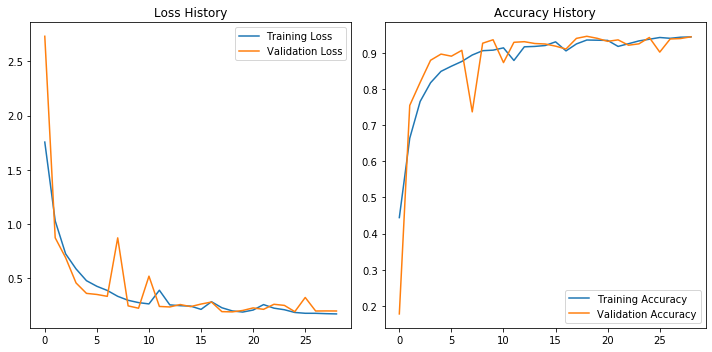

In [152]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

### Evaluating the model

In [157]:
augsud_model.evaluate(augsud_X_test, augsud_Y_test)

6561/6561 [==============================] - 1s 106us/step


[0.19262858636301122, 0.9455875628715135]

In [158]:
augsud_Y_pred = augsud_model.predict(augsud_X_test)
augsud_Y_pred_classes = np.argmax(augsud_Y_pred, axis=1)
print(classification_report(augsud_Y_test, augsud_Y_pred_classes, digits=3))

              precision    recall  f1-score   support

           0      0.986     0.994     0.990      3255
           1      0.905     0.860     0.882       400
           2      0.970     0.893     0.930       364
           3      0.904     0.963     0.933       438
           4      0.907     0.902     0.904       325
           5      0.919     0.835     0.875       327
           6      0.986     0.927     0.956       383
           7      0.894     0.927     0.910       327
           8      0.813     0.881     0.846       361
           9      0.868     0.882     0.875       381

    accuracy                          0.946      6561
   macro avg      0.915     0.906     0.910      6561
weighted avg      0.946     0.946     0.946      6561



#### Correctly classified samples

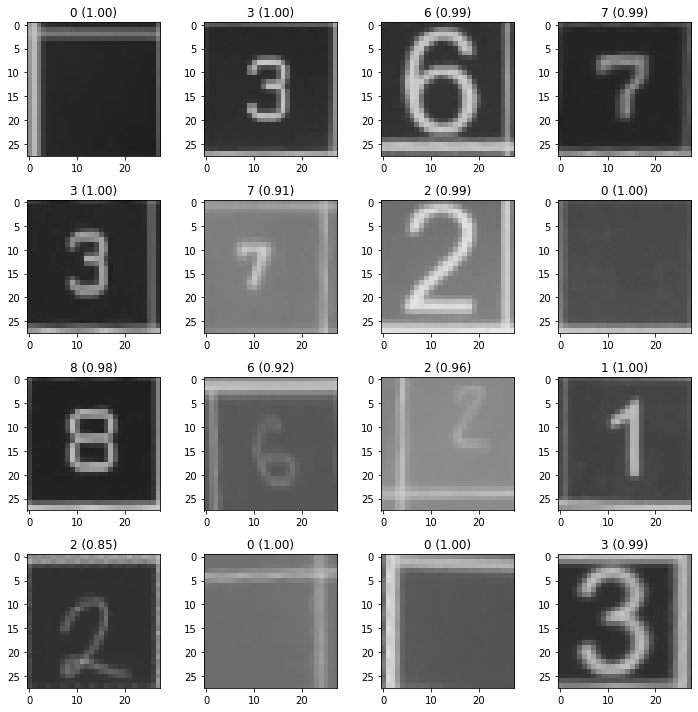

In [169]:
correct_examples = augsud_Y_pred_classes == augsud_Y_test
show_images(augsud_X_test[correct_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in augsud_Y_pred[correct_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Incorrectly classified samples

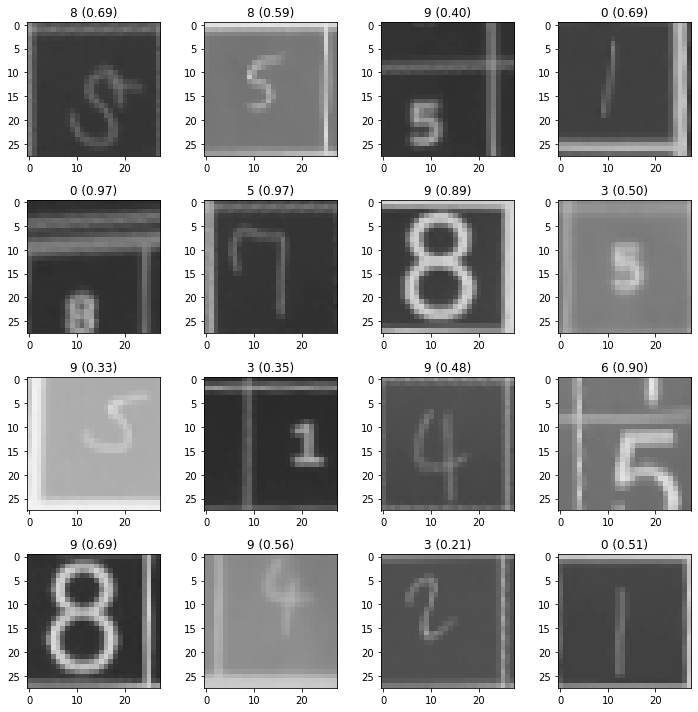

In [171]:
incorrect_examples = augsud_Y_pred_classes != augsud_Y_test
show_images(augsud_X_test[incorrect_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in augsud_Y_pred[incorrect_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

This model achieves an accuracy of about 95% on our test dataset - still not good enough for our use case.

## Transfer Learning

### Acquire dataset

As the dataset for the transfer learning process we use the "Augmented Sudoku dataset".

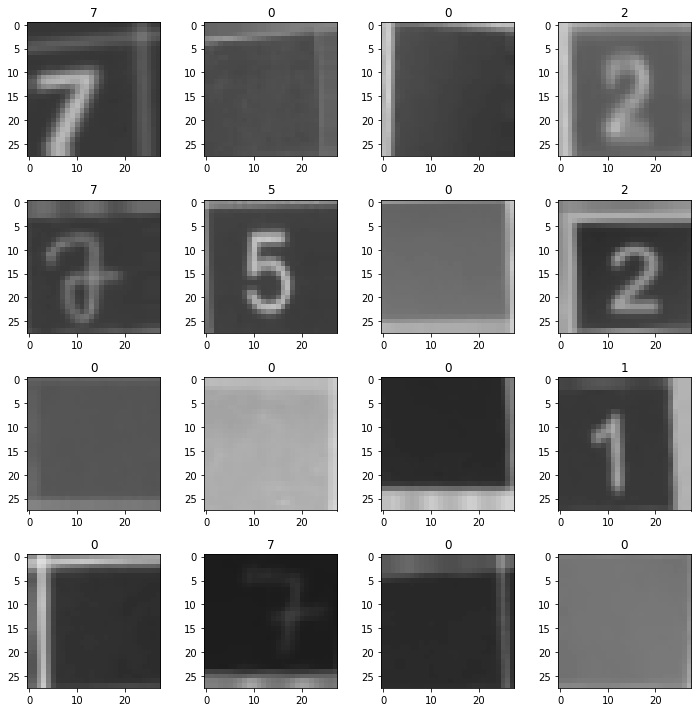

In [245]:
trans_train = augsud_train
trans_Y_train, trans_Y_test = sudnn_Y_train, sudnn_Y_test
show_images(*trans_train[0], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

### Building the model

The pretrained model is extracted from the "Augmented MNIST" model:
We take all but the last block of fully connected layers from it.

In [253]:
trans_model_pre_input = augmnist_model.get_input_at(0)
trans_model_pre = models.Model(trans_model_pre_input, augmnist_model.layers[-8].output)
trans_model_pre.trainable = False
trans_model_pre.summary()

Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_59 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_21 (Dropout)         (None, 12, 12, 32)        0  

The output of the pretrained model is fed into a new fully connected layer with size 10.
This layer is then set as the output of the composed model.

In [255]:
trans_model_input = trans_model_pre_input

# Prepend pretrained model
trans_model = trans_model_pre(trans_model_input)

# Fully Connected Block
#trans_model = layers.Dense(8, activation="relu")(trans_model)
#trans_model = layers.BatchNormalization()(trans_model)
#trans_model = layers.Dense(32, activation="relu")(trans_model)
#trans_model = layers.BatchNormalization()(trans_model)
#trans_model = layers.Dense(16, activation="relu")(trans_model)
#trans_model = layers.BatchNormalization()(trans_model)
#trans_model = layers.Dropout(0.5)(trans_model)

# Output
trans_model = layers.Dense(10, activation="softmax")(trans_model)

trans_model = models.Model(trans_model_input, trans_model)
trans_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
trans_model.summary()

Model: "model_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
model_74 (Model)             (None, 128)               98112     
_________________________________________________________________
dense_103 (Dense)            (None, 10)                1290      
Total params: 99,402
Trainable params: 1,290
Non-trainable params: 98,112
_________________________________________________________________


### Fitting the model

In [256]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight("balanced", np.unique(sudnn_Y_train), sudnn_Y_train)
class_weight

array([0.25682382, 1.4692429 , 1.45546875, 1.57082631, 1.54734219,
       1.48328025, 1.36184211, 1.45093458, 1.59503425, 1.36784141])

In [257]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
fit_history = trans_model.fit_generator(trans_train, 
                                        validation_data=(trans_X_test, trans_Y_test), 
                                        epochs=100, callbacks=[early_stopping], 
                                        class_weight=class_weight)

Epoch 1/100
292/292 [==============================] - 13s 44ms/step - loss: 0.8166 - acc: 0.7375 - val_loss: 0.4341 - val_acc: 0.8805
Epoch 2/100
292/292 [==============================] - 4s 14ms/step - loss: 0.2895 - acc: 0.9315 - val_loss: 0.3169 - val_acc: 0.9128
Epoch 3/100
292/292 [==============================] - 4s 14ms/step - loss: 0.1817 - acc: 0.9540 - val_loss: 0.2788 - val_acc: 0.9217
Epoch 4/100
292/292 [==============================] - 4s 14ms/step - loss: 0.1517 - acc: 0.9615 - val_loss: 0.2661 - val_acc: 0.9284
Epoch 5/100
292/292 [==============================] - 4s 15ms/step - loss: 0.1263 - acc: 0.9680 - val_loss: 0.2568 - val_acc: 0.9311
Epoch 6/100
292/292 [==============================] - 4s 15ms/step - loss: 0.1163 - acc: 0.9697 - val_loss: 0.2444 - val_acc: 0.9386
Epoch 7/100
292/292 [==============================] - 4s 15ms/step - loss: 0.1019 - acc: 0.9727 - val_loss: 0.2622 - val_acc: 0.9342
Epoch 8/100
292/292 [==============================] - 4s 14m

In [0]:
trans_model.save("trans_model.h5")
!cp "trans_model.h5" "./drive/My Drive/trans_model.h5"

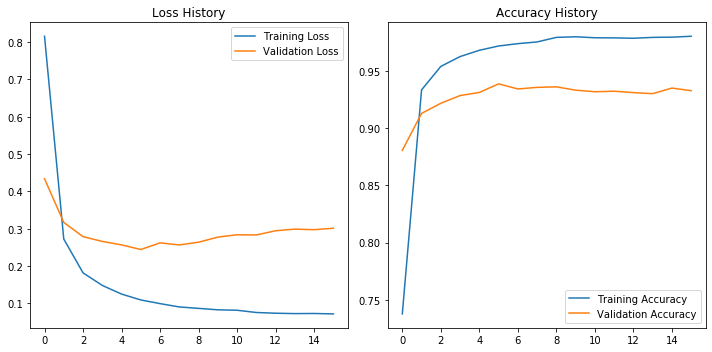

In [299]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Loss History")
plt.plot(fit_history.history["loss"], label="Training Loss")
plt.plot(fit_history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy History")
plt.plot(fit_history.history["acc"], label="Training Accuracy")
plt.plot(fit_history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

### Evaluating the model

In [259]:
trans_model.evaluate(trans_X_test, trans_Y_test)

6561/6561 [==============================] - 1s 108us/step


[0.24436886424266585, 0.9385764365188234]

In [258]:
trans_Y_pred = trans_model.predict(trans_X_test)
trans_Y_pred_classes = np.argmax(trans_Y_pred, axis=1)
print(classification_report(trans_Y_test, trans_Y_pred_classes, digits=3))

              precision    recall  f1-score   support

           0      0.928     1.000     0.963      3255
           1      0.983     0.735     0.841       400
           2      0.997     0.849     0.917       364
           3      0.949     0.934     0.941       438
           4      0.984     0.942     0.962       325
           5      0.919     0.902     0.910       327
           6      0.867     0.950     0.907       383
           7      0.936     0.853     0.893       327
           8      0.997     0.878     0.934       361
           9      0.957     0.866     0.909       381

    accuracy                          0.939      6561
   macro avg      0.952     0.891     0.918      6561
weighted avg      0.941     0.939     0.937      6561



#### Correctly classified samples

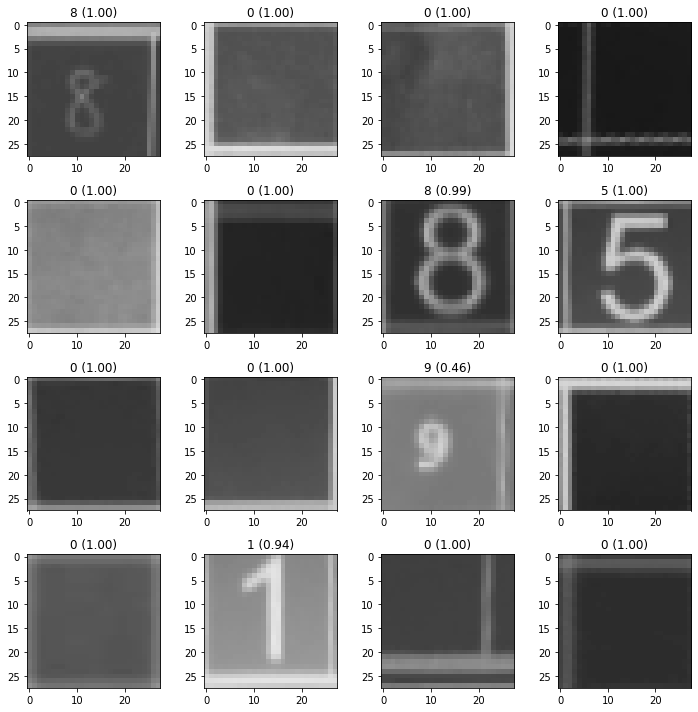

In [260]:
correct_examples = trans_Y_pred_classes == trans_Y_test
show_images(trans_X_test[correct_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in trans_Y_pred[correct_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Incorrectly classified samples

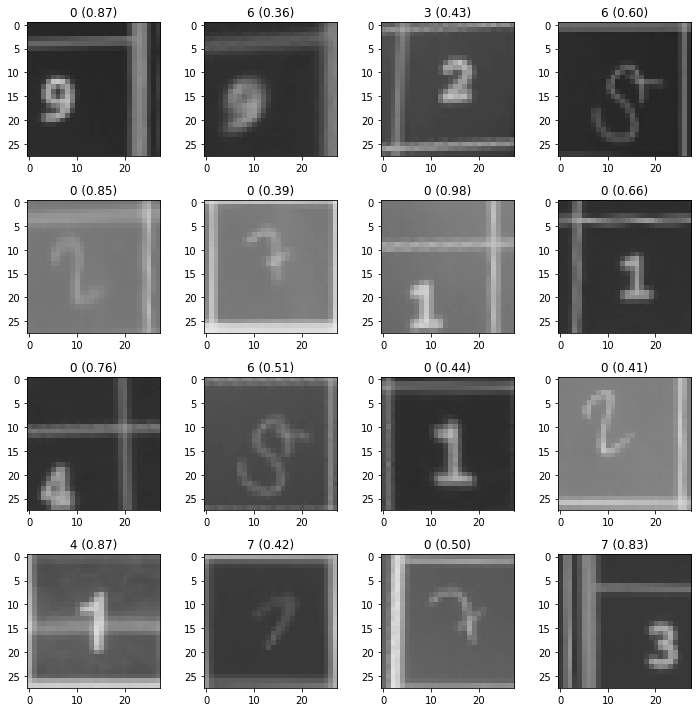

In [261]:
incorrect_examples = trans_Y_pred_classes != trans_Y_test
show_images(trans_X_test[incorrect_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in trans_Y_pred[incorrect_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

This model only achieves an accuracy of about 94% on our test dataset and so does not meet our expectations.

## Ensemble Learning

We train multiple small models and later average their outputs to get a better prediction than that of any single one of the original models.

In [277]:
def mm_build_model():
  sudnn_model = model_input = layers.Input(shape=(28, 28, 1))

  sudnn_model = layers.Conv2D(8, 3, activation="relu")(sudnn_model)
  sudnn_model = layers.BatchNormalization()(sudnn_model)
  sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
  sudnn_model = layers.GlobalMaxPool2D()(sudnn_model)
  sudnn_model = layers.BatchNormalization()(sudnn_model)
  sudnn_model = layers.Dropout(0.25)(sudnn_model)

  # sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
  # sudnn_model = layers.BatchNormalization()(sudnn_model)
  # sudnn_model = layers.Conv2D(10, 3, activation="relu")(sudnn_model)
  # sudnn_model = layers.GlobalMaxPool2D()(sudnn_model)
  # sudnn_model = layers.BatchNormalization()(sudnn_model)
  #sudnn_model = layers.Dropout(0.25)(sudnn_model)

  #model = layers.Flatten()(model)
  #model = layers.Dense(32, activation="relu")(model)
  #model = layers.BatchNormalization()(model)
  sudnn_model = layers.Dense(10, activation="softmax")(sudnn_model)
  sudnn_model = models.Model(model_input, sudnn_model)
  sudnn_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

  return sudnn_model

def mm_fit_model(model, train, test):
  early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
  fit_history = model.fit(*train, validation_data=test, 
                          epochs=100, callbacks=[early_stopping], 
                          class_weight=class_weight)
  return fit_history

mm_n_models = 10
mm_models = []
for i in range(mm_n_models):
  model = mm_build_model()
  mm_fit_model(model, (sudnn_X_train, sudnn_Y_train), (sudnn_X_test, sudnn_Y_test))
  mm_models.append(model)

Train on 9315 samples, validate on 6561 samples
Epoch 1/100
9315/9315 [==============================] - 16s 2ms/step - loss: 1.5303 - acc: 0.5229 - val_loss: 1.3925 - val_acc: 0.6414
Epoch 2/100
9315/9315 [==============================] - 3s 358us/step - loss: 0.8847 - acc: 0.7415 - val_loss: 0.8386 - val_acc: 0.7296
Epoch 3/100
9315/9315 [==============================] - 4s 380us/step - loss: 0.6304 - acc: 0.8143 - val_loss: 0.7790 - val_acc: 0.7510
Epoch 4/100
9315/9315 [==============================] - 3s 376us/step - loss: 0.5033 - acc: 0.8499 - val_loss: 0.6668 - val_acc: 0.7846
Epoch 5/100
9315/9315 [==============================] - 3s 349us/step - loss: 0.4375 - acc: 0.8657 - val_loss: 0.5430 - val_acc: 0.8340
Epoch 6/100
9315/9315 [==============================] - 3s 359us/step - loss: 0.3934 - acc: 0.8780 - val_loss: 0.4642 - val_acc: 0.8362
Epoch 7/100
9315/9315 [==============================] - 3s 371us/step - loss: 0.3640 - acc: 0.8847 - val_loss: 0.4911 - val_acc: 0

In [0]:
mm_Y_pred = [model.predict(sudnn_X_test) for model in mm_models]

In [0]:
mm_Y_pred_ensemble = np.mean(mm_Y_pred, axis=0)
mm_Y_pred_ensemble_classes = np.argmax(mm_Y_pred_ensemble, axis=1)

In [301]:
print(classification_report(sudnn_Y_test, mm_Y_pred_ensemble_classes, digits=3))

              precision    recall  f1-score   support

           0      0.976     1.000     0.988      3255
           1      0.931     0.882     0.906       400
           2      0.971     0.909     0.939       364
           3      0.914     0.975     0.944       438
           4      0.856     0.898     0.877       325
           5      0.964     0.743     0.839       327
           6      0.947     0.937     0.942       383
           7      0.905     0.933     0.919       327
           8      0.943     0.873     0.906       361
           9      0.891     0.927     0.909       381

    accuracy                          0.950      6561
   macro avg      0.930     0.908     0.917      6561
weighted avg      0.950     0.950     0.949      6561



Although each individual model only has an accuracy of about 90% the ensemble classifier reaches an accuracy of about 96%.

#### Correctly classified samples

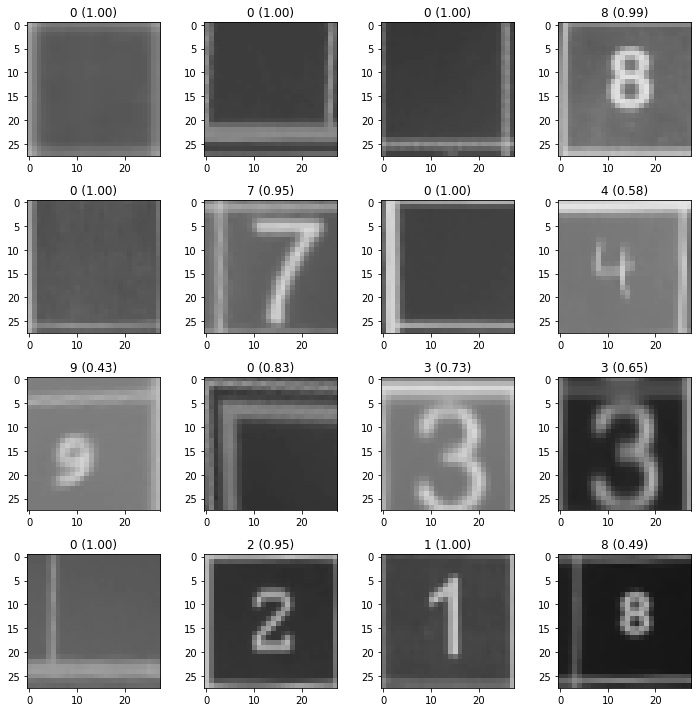

In [302]:
correct_examples = mm_Y_pred_ensemble_classes == sudnn_Y_test
show_images(sudnn_X_test[correct_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in mm_Y_pred_ensemble[correct_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Incorrectly classified samples

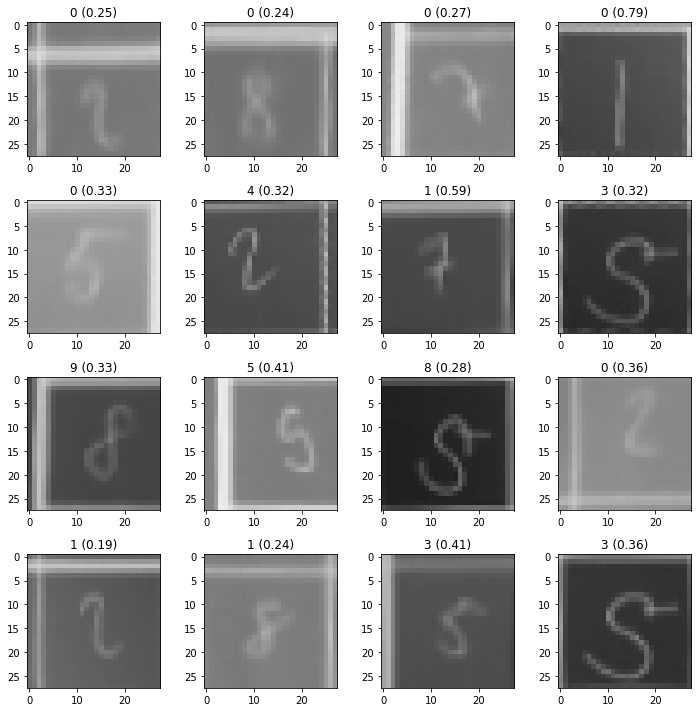

In [304]:
incorrect_examples = mm_Y_pred_ensemble_classes != sudnn_Y_test
show_images(sudnn_X_test[incorrect_examples], ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in mm_Y_pred_ensemble[incorrect_examples]], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

# Predictions

In [306]:
x = [nn_mnist_preprocess(cell) for cell in dataset["cell_image"]]
x = np.array(x)
x.shape

(15876, 28, 28, 1)

In [307]:
dataset["recog_x"] = x.tolist()
dataset["recog_x"]

input_filename                                                         cell_row  cell_col
./v2_train/image1066.jpg                                               0         0           [[[0.6563525199890137], [0.7034914493560791], ...
                                                                                 1           [[[0.7610694169998169], [0.7590811252593994], ...
                                                                                 2           [[[0.7470788955688477], [0.7420292496681213], ...
                                                                                 3           [[[0.7633804082870483], [0.7644457221031189], ...
                                                                                 4           [[[0.7087110280990601], [0.7213910818099976], ...
                                                                                                                   ...                        
./sudoku_dataset_1024/train_247994761_full/IMG_20200

In [308]:
y = augsud_model.predict(x)
y.shape

(15876, 10)

In [309]:
dataset["recog_y"] = y.tolist()
dataset["recog_y"]

input_filename                                                         cell_row  cell_col
./v2_train/image1066.jpg                                               0         0           [1.6228668187068251e-07, 0.9999792575836182, 7...
                                                                                 1           [0.999842643737793, 3.496154022286646e-05, 3.3...
                                                                                 2           [0.9999245405197144, 2.1232257495285012e-05, 7...
                                                                                 3           [0.9994569420814514, 2.649949055921752e-05, 3....
                                                                                 4           [0.9998006224632263, 7.954375178087503e-05, 1....
                                                                                                                   ...                        
./sudoku_dataset_1024/train_247994761_full/IMG_20200

In [310]:
digit = np.argmax(y, axis=1)
digit.shape

(15876,)

In [312]:
dataset["recog_digit"] = digit.tolist()
dataset["recog_digit"]

input_filename                                                         cell_row  cell_col
./v2_train/image1066.jpg                                               0         0           1
                                                                                 1           0
                                                                                 2           0
                                                                                 3           0
                                                                                 4           0
                                                                                            ..
./sudoku_dataset_1024/train_247994761_full/IMG_20200115_165329872.jpg  8         4           3
                                                                                 5           6
                                                                                 6           8
                                                       

# Export

In [313]:
df = dataset[["recog_x", "recog_y", "recog_digit"]]
df

recog_x  ... recog_digit
input_filename                                     cell_row cell_col                                                     ...            
./v2_train/image1066.jpg                           0        0         [[[0.6563525199890137], [0.7034914493560791], ...  ...           1
                                                            1         [[[0.7610694169998169], [0.7590811252593994], ...  ...           0
                                                            2         [[[0.7470788955688477], [0.7420292496681213], ...  ...           0
                                                            3         [[[0.7633804082870483], [0.7644457221031189], ...  ...           0
                                                            4         [[[0.7087110280990601], [0.7213910818099976], ...  ...           0
...                                                                                                                 ...  ...         ...
./sudoku_dataset_1024/train_247994761_full/IMG_... 8        4         [[[0.44692879915237427], [0.5337010025978088],...  ...           3
                                                            5         [[[0.4642156958580017], [0.3906787633895874], ...  ...           6
                                                            6         [[[0.6724615693092346], [0.37446480989456177],...  ...           8
                                                            7         [[[0.37842389941215515], [0.3177095949649811],...  ...           7
                                                            8         [[[0.35623252391815186], [0.35217463970184326]...  ...           8

[15876 rows x 3 columns]

In [0]:
df.to_pickle("./sudoku_recognition_output.bz2")

In [0]:
!cp "./sudoku_recognition_output.bz2" "./drive/My Drive/sudoku_recognition_output.bz2"